## NWM Notebook 4: Retrieving Archived NWM Forecasts from Google Cloud Platform (GCP) Storage with Hydrotools

<strong><em>Created by <a href="https://www.linkedin.com/in/justin-hunter-0b86871a6/" target="_blank">Justin Hunter</a>, <a href="https://www.linkedin.com/in/danames/" target="_blank">Dr. Dan Ames</a>, and <a href="https://www.linkedin.com/in/easton-perkins-02968a156/" target="_blank">Easton Perkins</a> in collaboration with <a href="https://www.cuahsi.org" target="_blank">CUAHSI</a>.</em></strong><br>
<em><strong>2022. Brigham Young University. Provo, Utah.
<a href="https://hydroinformatics.byu.edu" target="_blank">BYU Hydroinformatics Lab</a>.</em></strong>

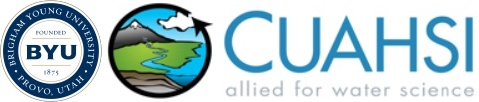

This Jupyter notebook uses the Hydrotools NWM Client Python package to retrieve NWM forecasts from Google Cloud Storage where NWM forecasts are stored. Data from September of 2018 through today is avaible there. This data can be accessed manually at: 

https://console.cloud.google.com/storage/browser/national-water-model;tab=objects?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&prefix=&forceOnObjectsSortingFiltering=false

We will also use Hydrotools to retrieve data from the NOAA Operational Model Archive and Distribution System (NOMADS) as was done in previous notebooks. Those files can be accessed manually at:

https://nomads.ncep.noaa.gov/pub/data/nccf/com/nwm/

Hydrotools only returns NWM reaches that have an associated USGS gauge. 7500+ reaches of the National Water Model are available via Hydrotools. Hydrotools is described as a suite of tools for retrieving USGS NWIS observations and evaluating NWM data. Documentation can be viewed at https://noaa-owp.github.io/hydrotools/. Hydrotools is still a work in progress. To report bugs or request new features, submit an issue through the <a href="https://github.com/NOAA-OWP/hydrotools/issues">OWP HydroTools Issue Tracker</a> on GitHub. One advantage to Hydrotools compared to methods used in previous NWM Notebooks is that it doesn't actually download NWM netcdf forecast files to your device or to your Jupyter file browser. Check it out by running the code in this notebook and reading along with the notes and comments provided here.

<em><h4>Imports</h4></em>

This next cell imports a few different Python modules or packages that will be used in this notebook. The functionality of this notebook depends on these packages. If significant changes are made to a package it could affect the notebook. The package version numbers originally used for some of the packages are included below along with a brief explanation of what each package will be used for.
* Hydrotools is used to retrieve National Water Model forecasts. (5.0.1)
* Pandas is used to help handle the forecast data in Python. (1.4.0)
* Matplotlib allows us to create some forecast plots here in this notebook. 

In [ ]:
!pip install hydrotools.nwm_client
from hydrotools.nwm_client import http as nwm
from hydrotools.nwm_client import gcp
import pandas as pd
import matplotlib.pyplot as plt

<em><h4>NOMADS</h4></em>

First we are going to use Hydrotools to retrieve NWM forecasts from NOMADS. Previous NWM Notebooks also retrieved forecasts from NOMADS but Hydrotools works a little differently.

Remember that NOMADS only provides the current and previous day's NWM forecasts. Also, the NOMADS file directory that we are retrieving forecasts from operates on UTC time. It's important to understand that time difference. As an example, if it is 6 PM on Feburary 3rd and you are on MST time, it is 1 AM on February 4th for the NWM and for the NOMADS file directory. That means that if you try to retrieve February 2nd forecast files, they won't be available because the NOMADS directory operates on a two-day rolling window and would only have February 3rd forecasts and the February 4th forecasts as they become available throughout that day. <strong>Ensure that you provide a valid date below with that information in mind.</strong>

The date should be entered in as the reference_time for the forecast_data variable below. The first 8 characters of this variable should be the forecast date in YYYYMMDD format. The last 4 characters indicate the starting timestep for the forecast. For example, entering "YYYYMMDDT02Z" with a short range configuration will retrieve the short range forecast beginning at 3 AM UTC. Entering "YYYYMMDDT01Z" will retrieve the forecast beginning at 2 AM UTC (for the specified day). Entering "YYYYMMDDT00Z" will retrieve the forecast beginning at 1 AM UTC for the specified day. When using medium and long range configurations remember that these operate on different timesteps than short range forecasts. It is best to work with six hour intervals and use reference times such as "YYYYMMDDT00Z", "YYYYMMDDT06Z", "YYYYMMDDT12Z", etc. 

The configuration indicates the forecast type to be retrieved. The next cell will print out the available configurations. 

In [ ]:
# Provide NOMADS file directory url
server = "https://nomads.ncep.noaa.gov/pub/data/nccf/com/nwm/prod/"
model_data_service = nwm.NWMDataService(server)
# Print out available configurations
print(model_data_service.configurations)

In [ ]:
# Retrieve forecast for the given reference_time and configuration from NOMADS
# BE SURE TO SET THE REFERENCE_TIME APPROPRIATELY FOR NOMADS AS EXPLAINED ABOVE
forecast_data = model_data_service.get(
    configuration = "short_range",
    reference_time = "20220317T01Z"
)

In [ ]:
# Now we have a Pandas DataFrame with our requested forecast
forecast_data

Take a close look at how this DataFrame is organized. If you retrieved a short range forecast there should be 18 rows (for 18 hours) per nwm_feature_id. Dividing the number of rows by 18 will then tell you how many unique nwm_feature_ids are included in the data. Medium range forecasts go out 10 days and will yield 240 rows per nwm_feature_id for member 1 or 204 rows per nwm_feature_id for other members. Long range forecasts go out 30 days at 6 hour intervals and will yield 120 rows per nwm_feature_id. 

Now that we've seen how to use Hydrotools to get NWM forecasts from NOMADS into a Pandas DataFrame, let's try retrieving older forecasts from Google Cloud Platform. 

<em><h4>Google Cloud Platform</h4></em>

The configuration and reference_time can be edited as described above. Ensure that you provide a valid configuration and reference_time. The next cell will display all of the available configurations.

In [ ]:
# Specify service
service=gcp.NWMDataService()
# Print out possible configurations
print(service.configurations)

In [ ]:
# Retrieve a specified forecast from the indicated GCP service
# Be sure to provide a valid reference_time. The one here by default will work. 
df = service.get(
    configuration = "short_range", 
    reference_time = "20190131T00Z"
)

In [ ]:
# Now we have a Pandas DataFrame with our requested forecast from GCP
df

Now that we have this NWM data in a Pandas DataFrame, we can subset it for a specific nwm_feature_id and visualize that forecast here. Let's pick nwm_feature_id "3109". Feel free to pick another nwm_feature_id and edit the following cell if desired.

<em><h4>Subsetting, Plotting, and Exporting</h4></em>

In [ ]:
# Subset the DataFrame with our retrieved forecast for an indicated reach
myreach = df.loc[df["nwm_feature_id"]==3109]

In [ ]:
myreach

Now that we've extracted the forecast for our desired reach, let's visualize it using matplotlib.

In [ ]:
# Set figure size
plt.rcParams["figure.figsize"] = (18,5.5)

In [ ]:
# Plot myreach as a scatter plot, specify axes
myreach.plot(kind='scatter',x='value_time',y='value',color='red')
# Show plot
plt.show()

Now let's extract the forecast for our indicated reach to a CSV file using Pandas.

In [ ]:
myreach.to_csv("myreach.csv")

Now let's extract the entire forecast that we retrieved from Google cloud platform to a CSV file.

In [ ]:
df.to_csv("gcp_fc.csv")

Looking through that CSV would be one way to see which reaches are available through Hydrotools. Now let's extract the forecast that we retrieved from NOMADS using Hydrotools to a CSV file.

In [ ]:
forecast_data.to_csv("NOMADSData.csv")

Those CSV files should be showing up in your Jupyter file browser. Now that we've seen how to subset, plot, and export forecasts that we've retrieved with Hydrotools, let's look at how we would subset for multiple reaches. This is very easy with Pandas. Hydrotools allows us to retrieve forecasts directly into Pandas DataFrames which are easy to work with. Let's put a few reaches in a list and then builed a DataFrame with their forecasts. Feel free to change up the reaches.

In [ ]:
# Create a list with my desired reach ids
myreaches_list = [3109,12932,1180000535]

In [ ]:
# Initialize an empty DataFrame
myreaches_df = pd.DataFrame()
# Add each reach's forecast from the DataFrame we retrieved from GCP to our new DataFrame
for i in myreaches_list:
    x = df.loc[df["nwm_feature_id"]==i]
    myreaches_df = pd.concat([myreaches_df,x])

In [ ]:
myreaches_df

That leaves us with a Pandas DataFrame containing the forecast for all three of our desired reaches. Let's try plotting this DataFrame with matplotlib to see the forecasts for all 3 of our reaches side by side.

In [ ]:
myreaches_df.plot(kind='scatter',x='value_time',y='value',color='red')
plt.show()

That plot might be confusing without labels to indicate which forecast is which, but hopefully you've begun to see how Hydrotools, Pandas, and Matplotlib can be powerful tools to retrieve and analyze NWM forecasts. Matplotlib can make much more descriptive plots than this one. You can view their documentation at https://matplotlib.org/stable/.

<em><h4>USGS Stream Gauge Network</h4></em>

Earlier it was mentioned that Hydrotools only returns NWM reaches that have an associated USGS gauge. Not every reach id in the NWM will be returned via Hydrotools. In order to provide a convienient way to see what NWM reaches are retrieved with Hydrotools, a map of the USGS Stream Gauge network is included below. This map shows USGS Stream gauges. Clicking on a gauge will yield some metadata. The site_no is the USGS site code for a gauge and the feature_id is the associated NWM reach id for the gauge.

What you see in the next code cell is just HTML and running the cell will display the web page at https://byu-hydroinformatics.github.io/csb-b1qbj7/.

This is similar to what we did to display NWM Reaches on an OpenLayers JavaScript map in NWM Notebook 2. The source code for the USGS Stream Gauge map can be found at the following GitHub repository: https://github.com/BYU-Hydroinformatics/USGSGaugeMap_NWMNotebook4

In [ ]:
%%HTML
<html>
<head></head>
<body>
<iframe title="NWM Reaches" src="https://byu-hydroinformatics.github.io/csb-b1qbj7/" width=100% height=640>
</iframe>
</body>
</html>

That map will help you obtain valid NWM reach ids that are also included in the DataFrames retrieved via Hydrotools. Many reach ids on major rivers are available. 

<em><h4>Exercises</h4></em>

The last part of this notebook asks you to try a few things for yourself. Do your best to complete the 3 exercises below and/or answer the given questions by using what you've learned here. Feel free to add new cells to run any code that you might need to answer a question or complete a task.

1. Search online for a large storm or flood event for a major river sometime in the last few of years.  Retrieve a forecast for that river from Google Cloud Storage near the event date and plot it. Retrieve another forecast for the same reach a couple months prior to or after the event. Compare the two. How much larger was the flow during the event that you found? HINT: You'll need to retrieve forecasts from GCP for the correct dates and subset them for the desired reach id (you can get this from the stream gauge map above).

2. Retrieve a long-range forecast (either from GCP or NOMADS) for a reach id of your choice on a date of your choice. Subset that forecast for 3-4 reaches along the same river. Export that subset to a CSV file and use Excel or something similar to plot the forecasts.

3. Plot the same forecasts that you retrieved for Problem 2 using matplotlib or another Python plotting library of your choice. Try splitting out each reach's forecast into its own DataFrame and then plotting multiple DataFrames on the same plot. See if you can use Matplotlib to add a legend to the plot. Their documentation is available here: https://matplotlib.org/stable/index.html

Thank you for using this resource! 